# Bollinger Bands Backtest — BTC/USDT

Compares two Bollinger Bands strategies on the same BTC data and time window:

| Strategy | Logic |
|---|---|
| `BollingerMeanReversion` | Long below lower band, short above upper band |
| `BollingerBreakout` | Long above upper band, short below lower band |

Metrics are computed via `backtesting.compute_metrics`.

In [1]:
# ── Configuration ────────────────────────────────────────────────────────────
SYMBOL    = "BTC/USDT"
SINCE     = "2024-01-01"
UNTIL     = "2024-06-01"

BB_PERIOD  = 20      # rolling window for the moving average
BB_NUM_STD = 2.0     # band width in standard deviations
ROLLING_WINDOW = 168 # bars for rolling correlation — 1 week at 1h

In [2]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# make repo root importable when running from notebooks/
sys.path.insert(0, str(Path().resolve().parent))

from data.fetch import fetch_ohlcv
from strategies.single.basic.bollinger_bands import BollingerMeanReversion, BollingerBreakout
from backtesting.metrics import compute_metrics

## 1. Fetch Data

In [3]:
df = fetch_ohlcv(symbol=SYMBOL, since=SINCE, until=UNTIL)
print(f"Fetched {len(df):,} bars  |  {df.index[0]}  →  {df.index[-1]}")
df[["open", "high", "low", "close", "volume"]].head()

Fetched 3,649 bars  |  2024-01-01 00:00:00+00:00  →  2024-06-01 00:00:00+00:00


,open,high,low,close,volume
timestamp,,,,,
2024-01-01 00:00:00+00:00,42284.0,42551.7,42259.7,42472.1,209.688178
2024-01-01 01:00:00+00:00,42472.1,42777.7,42423.8,42613.9,378.607406
2024-01-01 02:00:00+00:00,42613.9,42643.8,42500.1,42581.8,205.883161
2024-01-01 03:00:00+00:00,42581.7,42594.2,42209.0,42335.7,355.416120
2024-01-01 04:00:00+00:00,42335.7,42399.4,42203.1,42399.4,265.479921


## 2. Helper: build equity curve from signals

In [4]:
def build_equity_curve(df_with_signals: pd.DataFrame) -> pd.Series:
    """Convert a signal column into a normalised equity curve starting at 1.0.

    Signal is shifted by 1 bar to avoid look-ahead bias.
    """
    position   = df_with_signals["signal"].shift(1).fillna(0)
    bar_ret    = df_with_signals["close"].pct_change().fillna(0)
    strat_ret  = position * bar_ret
    equity     = (1 + strat_ret).cumprod()
    equity.name = "equity"
    return equity

## 3. BollingerMeanReversion

In [5]:
mr_strategy = BollingerMeanReversion(period=BB_PERIOD, num_std=BB_NUM_STD)
mr_df       = mr_strategy.generate_signals(df)
mr_equity   = build_equity_curve(mr_df)
mr_metrics  = compute_metrics(mr_equity)

print(mr_strategy)
print(f"Signal counts:\n{mr_df['signal'].value_counts().sort_index()}")

BollingerMeanReversion(period=20, num_std=2.0)
Signal counts:
signal
-1     226
 0    3228
 1     195
Name: count, dtype: int64


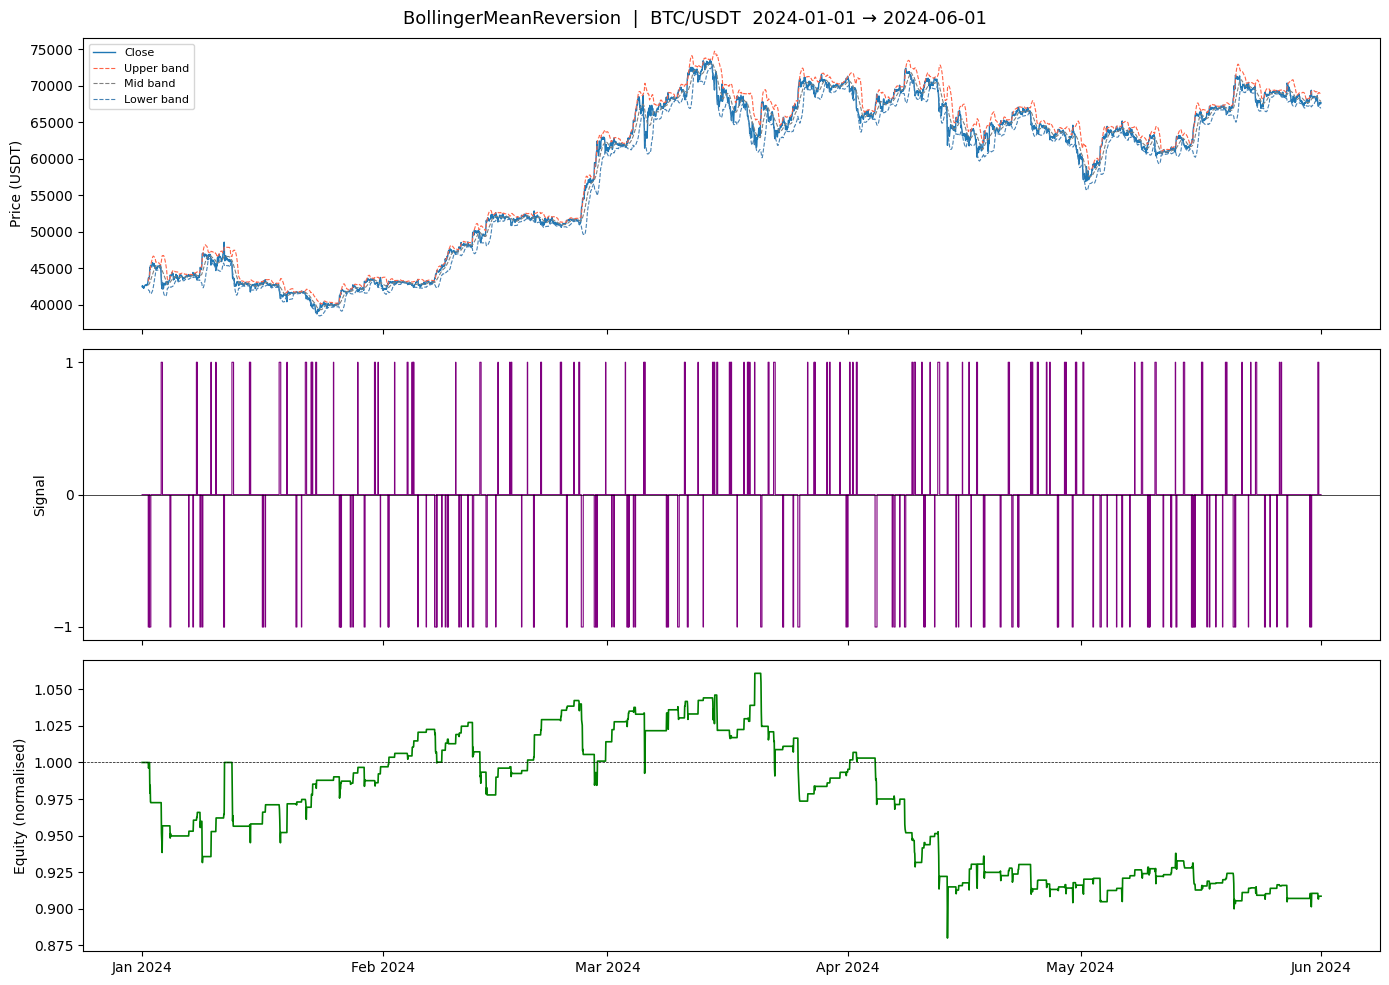

In [6]:
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
fig.suptitle(f"BollingerMeanReversion  |  {SYMBOL}  {SINCE} → {UNTIL}", fontsize=13)

ax = axes[0]
ax.plot(mr_df.index, mr_df["close"],    label="Close",       lw=1)
ax.plot(mr_df.index, mr_df["bb_upper"], label="Upper band",  lw=0.8, ls="--", color="tomato")
ax.plot(mr_df.index, mr_df["bb_mid"],   label="Mid band",    lw=0.8, ls="--", color="grey")
ax.plot(mr_df.index, mr_df["bb_lower"], label="Lower band",  lw=0.8, ls="--", color="steelblue")
ax.set_ylabel("Price (USDT)")
ax.legend(loc="upper left", fontsize=8)

ax = axes[1]
ax.step(mr_df.index, mr_df["signal"], where="post", lw=0.8, color="purple")
ax.axhline(0, color="black", lw=0.5)
ax.set_ylabel("Signal")
ax.set_yticks([-1, 0, 1])

ax = axes[2]
ax.plot(mr_equity.index, mr_equity, lw=1.2, color="green")
ax.axhline(1, color="black", lw=0.5, ls="--")
ax.set_ylabel("Equity (normalised)")
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))

plt.tight_layout()
plt.show()

## 4. BollingerBreakout

In [7]:
bo_strategy = BollingerBreakout(period=BB_PERIOD, num_std=BB_NUM_STD)
bo_df       = bo_strategy.generate_signals(df)
bo_equity   = build_equity_curve(bo_df)
bo_metrics  = compute_metrics(bo_equity)

print(bo_strategy)
print(f"Signal counts:\n{bo_df['signal'].value_counts().sort_index()}")

BollingerBreakout(period=20, num_std=2.0)
Signal counts:
signal
-1     195
 0    3228
 1     226
Name: count, dtype: int64


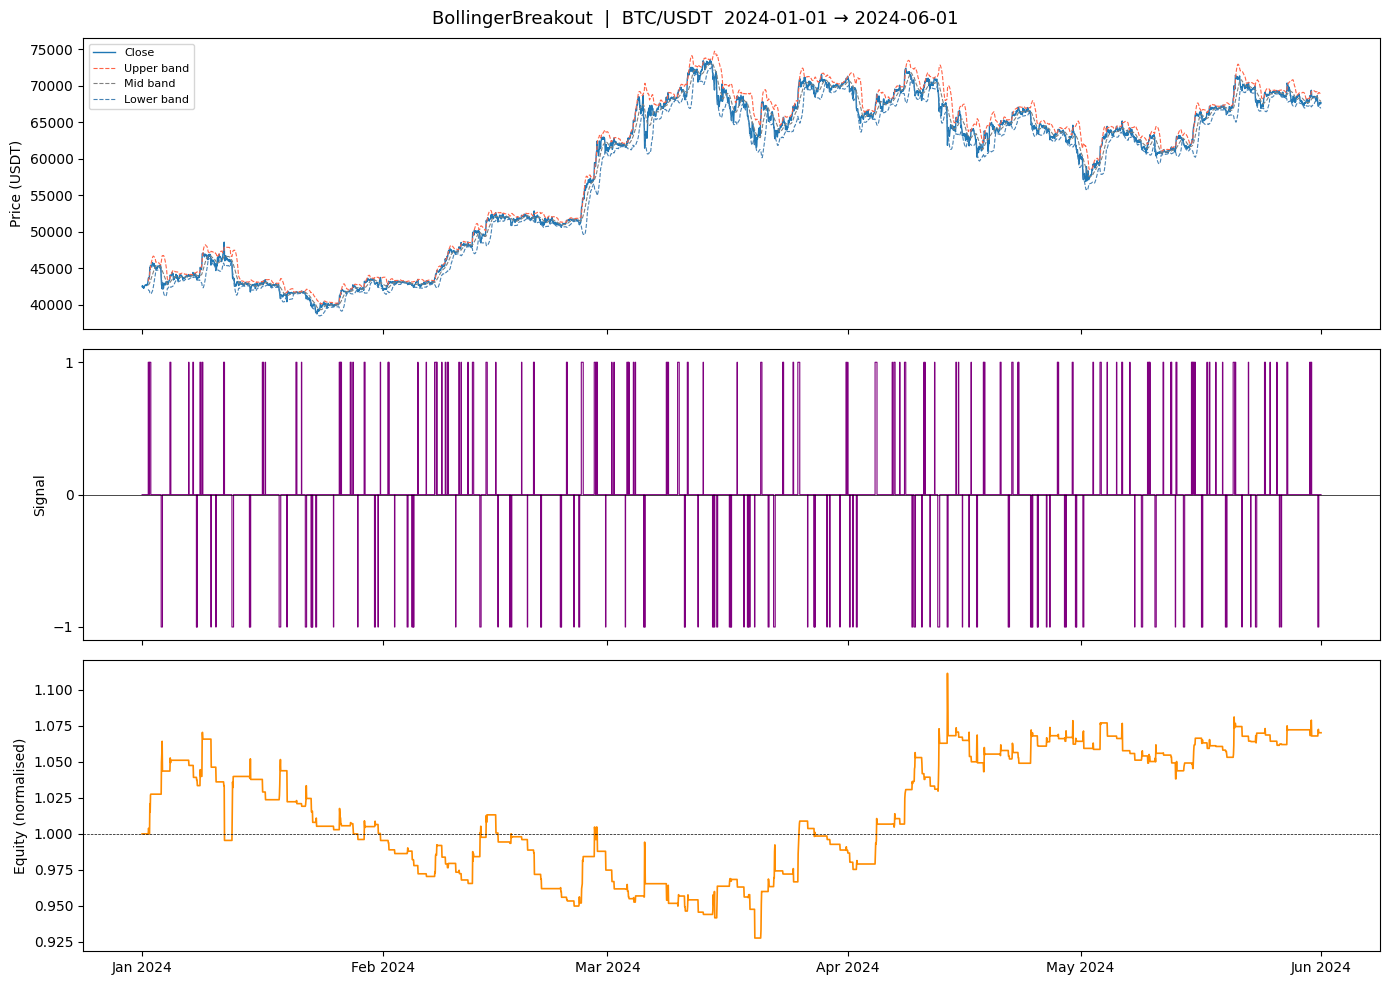

In [8]:
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
fig.suptitle(f"BollingerBreakout  |  {SYMBOL}  {SINCE} → {UNTIL}", fontsize=13)

ax = axes[0]
ax.plot(bo_df.index, bo_df["close"],    label="Close",       lw=1)
ax.plot(bo_df.index, bo_df["bb_upper"], label="Upper band",  lw=0.8, ls="--", color="tomato")
ax.plot(bo_df.index, bo_df["bb_mid"],   label="Mid band",    lw=0.8, ls="--", color="grey")
ax.plot(bo_df.index, bo_df["bb_lower"], label="Lower band",  lw=0.8, ls="--", color="steelblue")
ax.set_ylabel("Price (USDT)")
ax.legend(loc="upper left", fontsize=8)

ax = axes[1]
ax.step(bo_df.index, bo_df["signal"], where="post", lw=0.8, color="purple")
ax.axhline(0, color="black", lw=0.5)
ax.set_ylabel("Signal")
ax.set_yticks([-1, 0, 1])

ax = axes[2]
ax.plot(bo_equity.index, bo_equity, lw=1.2, color="darkorange")
ax.axhline(1, color="black", lw=0.5, ls="--")
ax.set_ylabel("Equity (normalised)")
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))

plt.tight_layout()
plt.show()

## 5. Side-by-side Comparison

In [9]:
comparison = pd.DataFrame({
    "MeanReversion": mr_metrics,
    "Breakout":      bo_metrics,
})

pct_rows = {"total_return", "mean_return", "std_return",
            "mean_neg_return", "std_neg_return",
            "return_p05", "return_p25", "return_p75", "return_p95",
            "max_drawdown", "win_rate"}

def fmt(row_name, val):
    if pd.isna(val):
        return "nan"
    return f"{val*100:.2f}%" if row_name in pct_rows else f"{val:.4f}"

formatted = comparison.apply(
    lambda col: [fmt(idx, v) for idx, v in col.items()]
)
formatted.index = comparison.index
formatted

,MeanReversion,Breakout
total_return,-9.14%,7.03%
mean_return,-0.00%,0.00%
std_return,0.28%,0.28%
sharpe_ratio,-0.7582,0.7582
sortino_ratio,-0.3002,0.4183
mean_neg_return,-0.64%,-0.48%
std_neg_return,0.70%,0.50%
return_p05,-0.01%,-0.16%
return_p25,0.00%,0.00%
return_p75,0.00%,0.00%


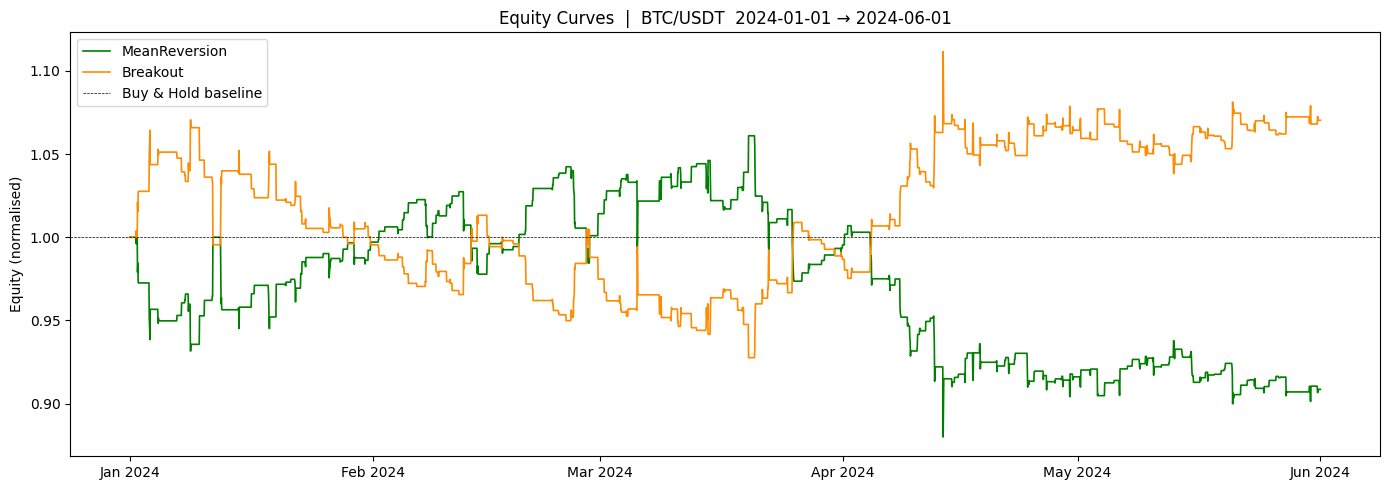

In [10]:
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(mr_equity.index, mr_equity, label="MeanReversion", color="green",      lw=1.2)
ax.plot(bo_equity.index, bo_equity, label="Breakout",      color="darkorange", lw=1.2)
ax.axhline(1, color="black", lw=0.5, ls="--", label="Buy & Hold baseline")
ax.set_title(f"Equity Curves  |  {SYMBOL}  {SINCE} → {UNTIL}")
ax.set_ylabel("Equity (normalised)")
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
ax.legend()
plt.tight_layout()
plt.show()

## 6. Market Correlation Analysis

How do each strategy's returns co-move with BTC's own returns?

| View | What it tells you |
|---|---|
| **Overall correlation** | General alignment with the market |
| **Conditional correlation** | Does the strategy help more in up- or down-trends? |
| **Rolling correlation** | Is the relationship stable over time, or regime-dependent? |
| **Scatter plots** | Visual shape of the relationship |

In [11]:
# ── Build a shared returns DataFrame ─────────────────────────────────────────
market_ret  = df["close"].pct_change().rename("market")
mr_ret      = (mr_df["signal"].shift(1).fillna(0) * market_ret).rename("mean_reversion")
bo_ret      = (bo_df["signal"].shift(1).fillna(0) * market_ret).rename("breakout")
rets        = pd.concat([market_ret, mr_ret, bo_ret], axis=1).dropna()

# ── Overall Pearson correlation ───────────────────────────────────────────────
print("Overall Pearson correlation:")
display(rets.corr().style.format("{:.3f}").background_gradient(cmap="RdYlGn", vmin=-1, vmax=1))

Overall Pearson correlation:


,market,mean_reversion,breakout
market,1.000,0.056,-0.056
mean_reversion,0.056,1.000,-1.000
breakout,-0.056,-1.000,1.000


In [12]:
# ── Conditional correlation: bull bars vs bear bars ───────────────────────────
bull = rets[rets["market"] > 0]
bear = rets[rets["market"] < 0]

cond_corr = pd.DataFrame({
    "bull_mkt (mkt>0)": bull[["mean_reversion", "breakout"]].corrwith(bull["market"]),
    "bear_mkt (mkt<0)": bear[["mean_reversion", "breakout"]].corrwith(bear["market"]),
    "all_bars":         rets[["mean_reversion", "breakout"]].corrwith(rets["market"]),
})

print(f"Conditional correlation with market  ({len(bull):,} bull bars / {len(bear):,} bear bars):")
display(cond_corr.style.format("{:.3f}").background_gradient(cmap="RdYlGn", vmin=-1, vmax=1))

Conditional correlation with market  (1,879 bull bars / 1,768 bear bars):


,bull_mkt (mkt>0),bear_mkt (mkt<0),all_bars
mean_reversion,-0.048,0.189,0.056
breakout,0.048,-0.189,-0.056


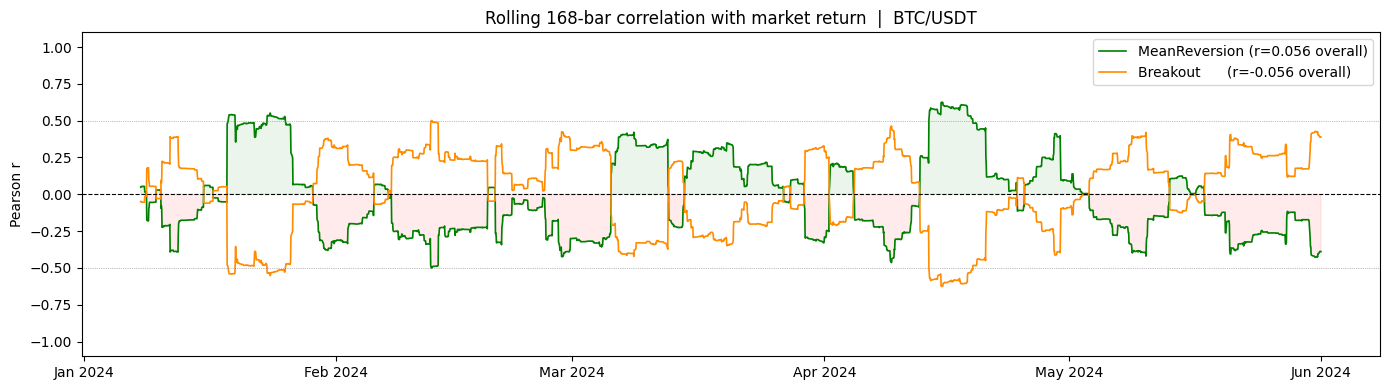

In [13]:
# ── Rolling correlation ───────────────────────────────────────────────────────
roll_mr = rets["mean_reversion"].rolling(ROLLING_WINDOW).corr(rets["market"])
roll_bo = rets["breakout"].rolling(ROLLING_WINDOW).corr(rets["market"])

fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(roll_mr.index, roll_mr,
        label=f"MeanReversion (r={rets['mean_reversion'].corr(rets['market']):.3f} overall)",
        color="green", lw=1.2)
ax.plot(roll_bo.index, roll_bo,
        label=f"Breakout      (r={rets['breakout'].corr(rets['market']):.3f} overall)",
        color="darkorange", lw=1.2)
ax.axhline( 0,   color="black", lw=0.8, ls="--")
ax.axhline( 0.5, color="grey",  lw=0.5, ls=":")
ax.axhline(-0.5, color="grey",  lw=0.5, ls=":")
ax.fill_between(roll_mr.index, roll_mr, 0, where=(roll_mr > 0), alpha=0.08, color="green")
ax.fill_between(roll_mr.index, roll_mr, 0, where=(roll_mr < 0), alpha=0.08, color="red")
ax.set_title(f"Rolling {ROLLING_WINDOW}-bar correlation with market return  |  {SYMBOL}")
ax.set_ylabel("Pearson r")
ax.set_ylim(-1.1, 1.1)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
ax.legend()
plt.tight_layout()
plt.show()

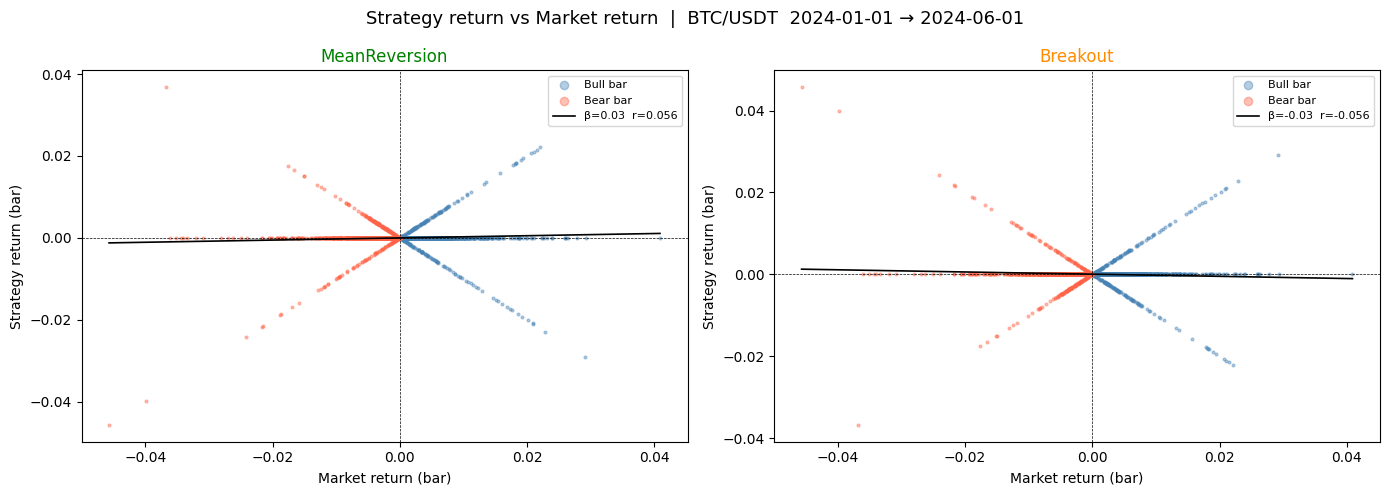

In [14]:
# ── Scatter plots: strategy return vs market return ───────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle(f"Strategy return vs Market return  |  {SYMBOL}  {SINCE} → {UNTIL}", fontsize=13)

for ax, col, label, color in [
    (axes[0], "mean_reversion", "MeanReversion", "green"),
    (axes[1], "breakout",       "Breakout",       "darkorange"),
]:
    mkt   = rets["market"]
    strat = rets[col]
    bull_mask = mkt > 0

    ax.scatter(mkt[bull_mask],  strat[bull_mask],  s=4, alpha=0.4, color="steelblue", label="Bull bar")
    ax.scatter(mkt[~bull_mask], strat[~bull_mask], s=4, alpha=0.4, color="tomato",    label="Bear bar")

    m, b   = np.polyfit(mkt, strat, 1)
    x_line = np.linspace(mkt.min(), mkt.max(), 100)
    ax.plot(x_line, m * x_line + b, color="black", lw=1.2,
            label=f"β={m:.2f}  r={mkt.corr(strat):.3f}")

    ax.axhline(0, color="black", lw=0.5, ls="--")
    ax.axvline(0, color="black", lw=0.5, ls="--")
    ax.set_xlabel("Market return (bar)")
    ax.set_ylabel("Strategy return (bar)")
    ax.set_title(label, color=color)
    ax.legend(fontsize=8, markerscale=3)

plt.tight_layout()
plt.show()